<a href="https://colab.research.google.com/github/GiovanniPioDelvecchio/NLP-Project/blob/main/Dataset%20statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 51.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.3 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
!wget https://zenodo.org/record/7550385/files/arguments-training.tsv
!wget https://zenodo.org/record/7550385/files/labels-training.tsv
!wget https://zenodo.org/record/7550385/files/arguments-validation.tsv
!wget https://zenodo.org/record/7550385/files/labels-validation.tsv
!wget https://zenodo.org/record/7550385/files/arguments-test.tsv
!wget https://zenodo.org/record/7550385/files/arguments-validation-zhihu.tsv
!wget https://zenodo.org/record/7550385/files/labels-validation-zhihu.tsv

--2023-02-07 15:23:31--  https://zenodo.org/record/7550385/files/arguments-training.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1012498 (989K) [application/octet-stream]
Saving to: ‘arguments-training.tsv’

arguments-training. 100%[===================>] 988.77K   403KB/s    in 2.5s    

2023-02-07 15:23:36 (403 KB/s) - ‘arguments-training.tsv’ saved [1012498/1012498]

--2023-02-07 15:23:36--  https://zenodo.org/record/7550385/files/labels-training.tsv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253843 (248K) [application/octet-stream]
Saving to: ‘labels-training.tsv’

labels-training.tsv 100%[===================>] 247.89K   386KB/s    in 0.6s    

2023-02-07 15:23:38 (386 KB/s) - ‘labels-training.tsv’ saved [253843/2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torchtext.data import get_tokenizer
from prettytable import PrettyTable

In [36]:
seed = 10

raw_training = pd.read_csv("arguments-training.tsv", encoding='utf-8', sep='\t', header=0)
raw_training_lab = pd.read_csv("labels-training.tsv", encoding='utf-8', sep='\t', header=0)
raw_test = pd.read_csv("arguments-validation.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_lab = pd.read_csv("labels-validation.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_chn = pd.read_csv("arguments-validation-zhihu.tsv", encoding='utf-8', sep='\t', header=0)
raw_test_chn_lab = pd.read_csv("labels-validation-zhihu.tsv", encoding='utf-8', sep='\t', header=0)

train = raw_training.join(raw_training_lab,how='inner' ,lsuffix='2') # joining labels
test = raw_test.join(raw_test_lab, how='inner', lsuffix='2') # joining labels
test_chn = raw_test_chn.join(raw_test_chn_lab, how='inner', lsuffix='2')
train, val = train_test_split(train, train_size=.80, random_state=seed) # splitting training

label_list = [col for col in train.columns.values if col not in ['Conclusion', 'Stance', 'Premise', 'labels', 'Argument ID', 'Argument ID2']]

In [30]:
def get_counts(df, label_list):
  df_counts = pd.DataFrame()
  for label in label_list:
    to_add = df.groupby(label)[label].count()
    try:
      df_counts = df_counts.append({"Attribute Name": label, "Count": to_add[1]}, ignore_index=True)
    except KeyError:
      df_counts = df_counts.append({"Attribute Name": label, "Count": 0}, ignore_index=True)
  return df_counts

def display_correlation_labels(df, label_list):
  df_counts = pd.DataFrame(columns=["Attribute"] + label_list)
  for label in label_list:
    _dict = {"Attribute": label}
    _dict.update({k:0.0 for k in label_list})
    df_counts = df_counts.append(_dict, ignore_index=True)

  for couple in list(itertools.combinations(label_list, 2)):
    to_add = df.groupby(list(couple)).size()
    try:
      df_counts.loc[df_counts["Attribute"] == couple[0], couple[1]] = float(to_add[1, 1])
      df_counts.loc[df_counts["Attribute"] == couple[1], couple[0]] = 0.0
    except KeyError:
      df_counts.loc[df_counts["Attribute"] == couple[0], couple[1]] = 0.0
      df_counts.loc[df_counts["Attribute"] == couple[1], couple[0]] = 0.0
  
  df_counts = df_counts.set_index("Attribute")
  return df_counts.style \
    .background_gradient(cmap='YlOrRd', axis=None) \
    .set_table_styles([{'selector': 'th', 'props': [('font-size', '8pt'), ('text-align', 'center')]}]) \
    .set_properties(**{'font-size': '10pt', 'width': '10pt', 'height': '10pt', 'text-align': 'center'}) \
    .format(precision=0)

In [31]:
df_counts_train = get_counts(train, label_list) 
df_counts_val = get_counts(val, label_list)
df_counts_test = get_counts(test, label_list)
df_counts_test_chn = get_counts(test_chn, l)

df_join_counts = df_counts_train.set_index("Attribute Name").join(df_counts_val.set_index("Attribute Name"), lsuffix="_train", rsuffix="_val")
df_join_counts = df_join_counts.join(df_counts_test.set_index("Attribute Name").rename(columns={"Count": "Count_test"}), lsuffix="_test", rsuffix="_test")
df_join_counts = df_join_counts.join(df_counts_test_chn.set_index("Attribute Name").rename(columns={"Count": "Count_test_chnn"}), lsuffix="_test", rsuffix="_test")

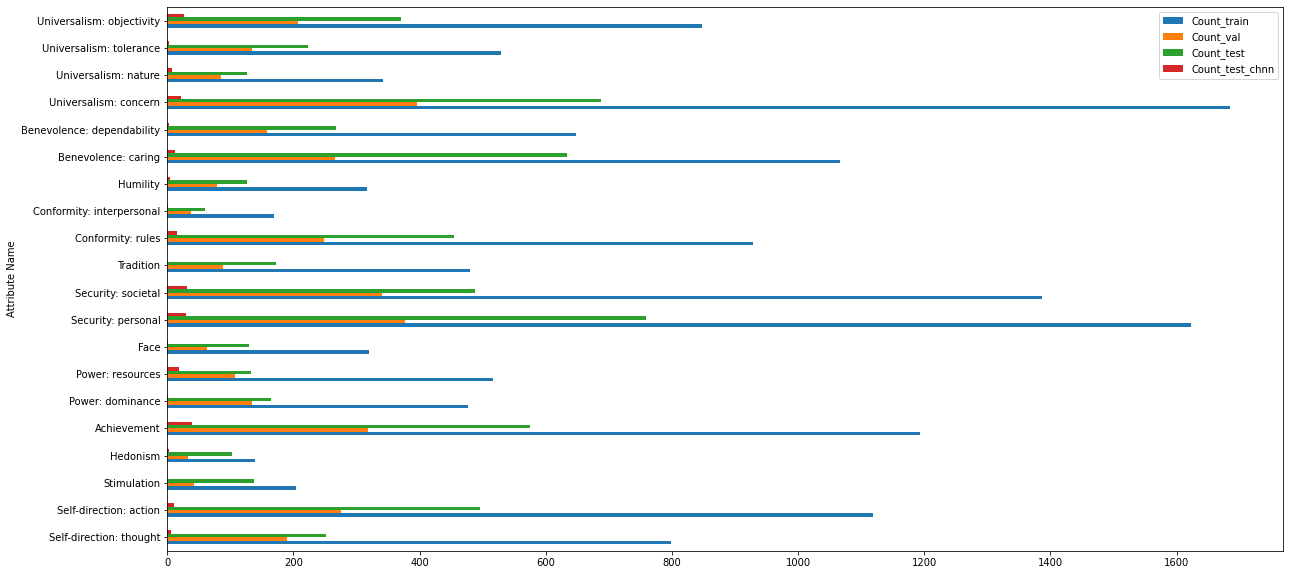

In [32]:
df_join_counts.plot(kind='barh', figsize=(20, 10));

In [33]:
display_correlation_labels(train, label_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Attribute,,,,,,,,,,,,,,,,,,,,
Self-direction: thought,0,427,72,36,288,73,55,66,193,102,138,90,13,30,159,51,206,24,174,220
Self-direction: action,0,0,106,75,258,131,112,93,361,199,184,144,58,54,233,99,351,35,189,211
Stimulation,0,0,0,46,86,11,28,30,95,29,16,14,5,11,55,17,48,21,51,26
Hedonism,0,0,0,0,35,3,16,20,86,13,11,6,3,11,39,8,30,13,29,10
Achievement,0,0,0,0,0,157,272,106,482,309,60,129,25,60,325,180,354,53,139,296
Power: dominance,0,0,0,0,0,0,47,57,105,226,38,118,10,21,104,85,222,9,57,92
Power: resources,0,0,0,0,0,0,0,35,268,138,22,45,10,24,112,73,170,17,22,83
Face,0,0,0,0,0,0,0,0,129,77,34,75,26,23,82,37,133,11,83,60
Security: personal,0,0,0,0,0,0,0,0,0,475,114,272,63,127,495,254,554,95,235,252


In [34]:
display_correlation_labels(val, label_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Attribute,,,,,,,,,,,,,,,,,,,,
Self-direction: thought,0,101,18,8,86,15,18,12,49,22,26,24,7,6,38,14,45,9,39,44
Self-direction: action,0,0,19,23,74,29,24,17,75,47,32,47,14,16,60,30,75,11,51,55
Stimulation,0,0,0,12,23,3,5,7,14,5,1,3,0,1,10,3,11,2,12,6
Hedonism,0,0,0,0,10,0,0,3,16,2,0,2,2,2,11,0,4,3,9,8
Achievement,0,0,0,0,0,51,59,28,105,78,20,44,7,14,95,47,83,17,35,69
Power: dominance,0,0,0,0,0,0,15,14,31,74,9,32,0,3,28,22,53,1,21,33
Power: resources,0,0,0,0,0,0,0,9,51,22,4,16,0,3,22,16,28,4,4,14
Face,0,0,0,0,0,0,0,0,18,13,6,13,3,4,17,10,28,4,15,11
Security: personal,0,0,0,0,0,0,0,0,0,89,17,65,9,34,117,58,120,22,39,55


In [35]:
display_correlation_labels(test, label_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Attribute,,,,,,,,,,,,,,,,,,,,
Self-direction: thought,0,137,41,37,93,22,3,14,58,25,22,41,8,13,59,14,40,12,56,53
Self-direction: action,0,0,55,42,132,56,40,28,181,67,45,70,14,34,170,47,136,26,84,85
Stimulation,0,0,0,47,53,13,4,16,66,17,9,20,4,9,51,15,24,4,34,10
Hedonism,0,0,0,0,25,5,0,10,50,8,7,10,4,11,36,6,11,8,18,15
Achievement,0,0,0,0,0,69,57,44,205,122,30,103,6,30,168,92,170,30,77,140
Power: dominance,0,0,0,0,0,0,6,18,46,76,14,41,5,7,43,35,64,8,22,32
Power: resources,0,0,0,0,0,0,0,2,99,23,1,13,0,6,34,26,50,4,5,16
Face,0,0,0,0,0,0,0,0,63,27,9,33,11,15,46,24,39,4,24,20
Security: personal,0,0,0,0,0,0,0,0,0,138,51,119,20,49,319,124,212,47,91,103


In [13]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
basic_tokenizer = get_tokenizer("basic_english")

In [19]:
def display_dataset_data(df, tokenizer, title):
  tokens = {"Premise": [], "Conclusion": []}
  columns = ["Premise", "Conclusion"]
  for index, row in df.iterrows():
    for column in columns:
      _tokenized = tokenizer(row[column])
      tokens[column].append(_tokenized["input_ids"] if "input_ids" in _tokenized else _tokenized)
  tokens_lengths = {}
  tokens_sets = {}
  table = PrettyTable(['Column', 'N. Unique', 'Mean Lengths', 'Min Tokens', 'Max Tokens', '90° Percentile'])

  for column in columns:
    tokens_lengths[column] = [len(sentence) for sentence in tokens[column]]
    tokens_sets[column] = set([token for sentence in tokens[column] for token in sentence])
    table.add_row([column, 
      len(tokens_sets[column]),
      str(round(np.mean(tokens_lengths[column]), 2)),
      np.min(tokens_lengths[column]),
      np.max(tokens_lengths[column]),
      str(round(np.quantile(tokens_lengths[column], 0.90), 2))
      ])

  print(table)
  fig, axs = plt.subplots(ncols=2, figsize=(25, 10))
  fig.suptitle(title)
  for idx, column in enumerate(columns):
    axs[idx].set_title('Lengths tokenized column ' + column)
    axs[idx].set_xlabel('Length')
    axs[idx].set_ylabel("Counts of row with same " + column + " length")
    sns.histplot(tokens_lengths[column], kde=False, 
                bins=50, color='blue', ax=axs[idx]);

+------------+-----------+--------------+------------+------------+----------------+
|   Column   | N. Unique | Mean Lengths | Min Tokens | Max Tokens | 90° Percentile |
+------------+-----------+--------------+------------+------------+----------------+
|  Premise   |    7253   |    23.34     |     4      |    148     |      37.0      |
| Conclusion |    909    |     6.44     |     4      |     35     |      10.0      |
+------------+-----------+--------------+------------+------------+----------------+


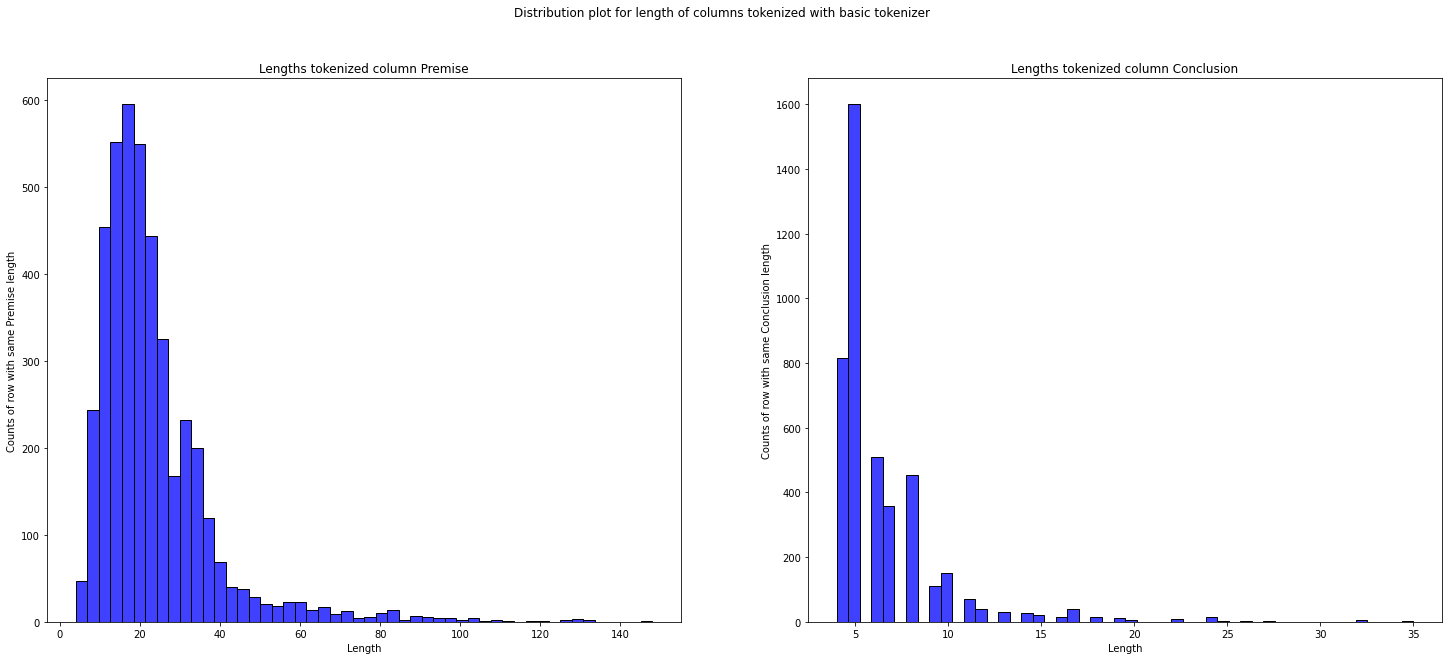

In [20]:
display_dataset_data(train, basic_tokenizer, "Distribution plot for length of columns tokenized with basic tokenizer")

+------------+-----------+--------------+------------+------------+----------------+
|   Column   | N. Unique | Mean Lengths | Min Tokens | Max Tokens | 90° Percentile |
+------------+-----------+--------------+------------+------------+----------------+
|  Premise   |    6997   |    26.88     |     6      |    159     |      42.0      |
| Conclusion |    1017   |     9.6      |     6      |     38     |      13.0      |
+------------+-----------+--------------+------------+------------+----------------+


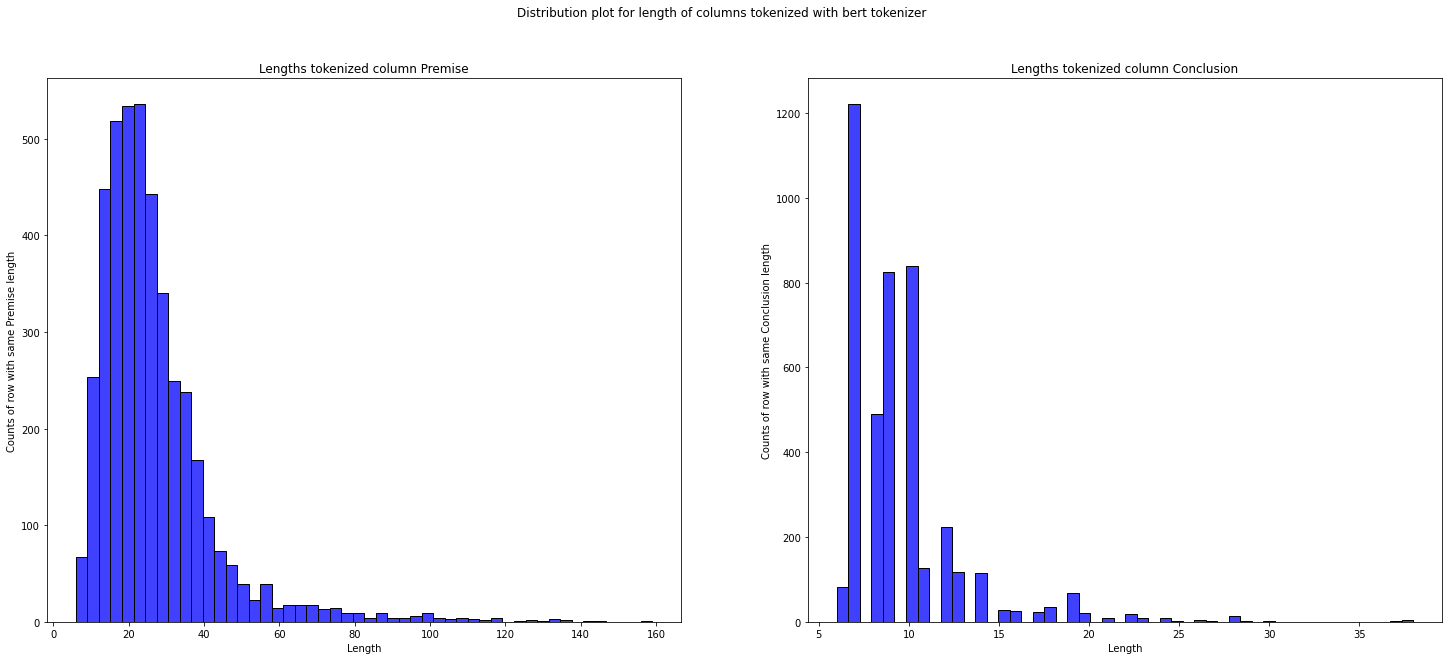

In [21]:
display_dataset_data(train, bert_tokenizer, "Distribution plot for length of columns tokenized with bert tokenizer")